<a href="https://colab.research.google.com/github/jornistr/my-first-repository/blob/master/211104_DB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Connect to my google drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install sentistrength

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
from sentistrength import PySentiStr

## Daten importieren

In [ ]:
tweets = pd.read_csv('/content/drive/MyDrive/21-09-03 DB NWOM/Datensatz (vollständig - 6 Monate)/twitter_export_tweets_1631616168847.csv', parse_dates=['Created At (UTC)'], header=1)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,8,21,22,27,28,29,31,32,33,34,37,67,68) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
tweets.head(5)

,ID,Text,Created At (UTC),Retweet count,Coordinates latitude,Coordinates longitude,Favorite count,Places ID,Places Name,Source,Author ID,Author name,Author screen name,Author created at (UTC),Author location,Author followers count,Author verified,Author description,Author statuses count,Author friends count,Original tweet ID (if retweet),Original tweet text (if retweet),Original tweet created at (if retweet),Original tweet retweet count (if retweet),Original tweet coordinates latitude (if retweet),Original tweet coordinates longitude (if retweet),Original tweet favorite count (if retweet),Original tweet places ID (if retweet),Original tweet places name (if retweet),Original tweet source (if retweet),Original tweet author ID (if retweet),Original tweet author name (if retweet),Original tweet author screen name (if retweet),Original tweet author created at (if retweet),Original tweet author location (if retweet),Original tweet author followers count (if retweet),Original tweet author verified (if retweet),Original tweet author description (if retweet),Original tweet author statuses count (if retweet),Original tweet author friends count (if retweet),Original tweet ID (if reply),Original tweet text (if reply),Original tweet created at (if reply),Original tweet retweet count (if reply),Original tweet coordinates latitude (if reply),Original tweet coordinates longitude (if reply),Original tweet favorite count (if reply),Original tweet places ID (if reply),Original tweet places name (if reply),Original tweet source (if reply),Original tweet author ID (if reply),Original tweet author name (if reply),Original tweet author screen name (if reply),Original tweet author created at (if reply),Original tweet author location (if reply),Original tweet author followers count (if reply),Original tweet author verified (if reply),Original tweet author description (if reply),Original tweet author statuses count (if reply),Original tweet author friends count (if reply),Original tweet ID (if comment),Original tweet text (if comment),Original tweet created at (if comment),Original tweet retweet count (if comment),Original tweet coordinates latitude (if comment),Original tweet coordinates longitude (if comment),Original tweet favorite count (if comment),Original tweet places ID (if comment),Original tweet places name (if comment),Original tweet source (if comment),Original tweet author ID (if comment),Original tweet author name (if comment),Original tweet author screen name (if comment),Original tweet author created at (if comment),Original tweet author location (if comment),Original tweet author followers count (if comment),Original tweet author verified (if comment),Original tweet author description (if comment),Original tweet author statuses count (if comment),Original tweet author friends count (if comment)
0,1118901879801618432,@dbsystel @DB_Bahn Feature request: mit Punkte...,2019-04-18 15:39:30,0,NaN,NaN,1,NaN,NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",3300320326,Frank Bernhard Übler,frnkbrnhrd,2015-05-27 09:20:10,"Leipzig, Sachsen",79,0,All is art.,3182,148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.118891e+18,"""BahnBonus ist ein Loyality-Programm für treue...",2019-04-18 14:58:03,2.0,NaN,NaN,8.0,NaN,NaN,"<a href=""http://www.falcon.io"" rel=""nofollow"">...",348465815.0,DB Systel,dbsystel,2011-08-04 13:43:37,"Frankfurt, Berlin, Erfurt",4073.0,0.0,"DB Systel, Digitalpartner der DB, gestaltet di...",4141.0,849.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1118902406782312451,"Der Moment, wenn Du im Zug sitzt und dich frag...",2019-04-18 15:41:36,0,NaN,NaN,1,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",19151442,Torsten Skomp,tskomp,2009-01-18 17:51:01,Deutschland,47,0,Teil einer Dimension / hier privat unterwegs /...,266,175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [ ]:
tweets['Created At (UTC)'] = pd.to_datetime(tweets['Created At (UTC)'], errors="coerce", format="%Y-%m-%d %H:%M:%S")

In [ ]:
tweets.dtypes

ID                                                             int64
Text                                                          object
Created At (UTC)                                      datetime64[ns]
Retweet count                                                  int64
Coordinates latitude                                         float64
                                                           ...      
Original tweet author followers count (if comment)           float64
Original tweet author verified (if comment)                  float64
Original tweet author description (if comment)                object
Original tweet author statuses count (if comment)            float64
Original tweet author friends count (if comment)             float64
Length: 80, dtype: object

## Korrekturen für's Paper

In [ ]:
# Paper says:
# „sample of 36,757 Twitter postings“
# Es sind aber mehr!

len(tweets)

380741

In [ ]:
# filter out retweets

tweets = tweets.loc[~tweets['Text'].str.startswith('RT @')]

len(tweets)

282529

In [ ]:
# Paper says:
# „we captured a total of sixty-six days of Twitter communication from April 18th, 2019 (0:00 UTC) to June 23rd, 2019 (23:59 UTC)”
# Es sind aber mehr!

tweets['Created At (UTC)'].max() - tweets['Created At (UTC)'].min()

Timedelta('182 days 23:52:03')

In [ ]:
# Startdatum stimmt überein

tweets['Created At (UTC)'].min()

Timestamp('2019-04-18 00:02:56')

In [ ]:
# Daten wurden aber bis Oktober erhoben

tweets['Created At (UTC)'].max()

Timestamp('2019-10-17 23:54:59')

## Autoren Informationen

In [ ]:
#There are N/A Values in 'Author name'
tweets['Author name'].isnull().value_counts()

False    282515
True         14
Name: Author name, dtype: int64

In [ ]:
#Replace screen names
tweets['Author name'] = tweets['Author name'].fillna(tweets['Author screen name'])
tweets['Author name'].isnull().value_counts()

False    282529
Name: Author name, dtype: int64

In [ ]:
#number of authors

print(str(len(tweets)) + ' = Total Tweets\n')

print(str(len(tweets['Author ID'].value_counts())) + ' = Unique Author IDs')
print(str(len(tweets['Author name'].value_counts())) + ' = Unique Author names')
print(str(len(tweets['Author screen name'].value_counts())) + ' = Unique Author screen names\n')

average_tweets = len(tweets['Author ID']) / len(tweets['Author ID'].value_counts())
print('Average tweets per author: ' + str(round(average_tweets, 2)))

282529 = Total Tweets

53960 = Unique Author IDs
49894 = Unique Author names
53955 = Unique Author screen names

Average tweets per author: 5.24


## Sentiment Analysis

In [ ]:
senti = PySentiStr()
senti.setSentiStrengthPath('/content/drive/MyDrive/21-09-03 DB NWOM/SentiStrengthCom.jar')
senti.setSentiStrengthLanguageFolderPath('/content/drive/MyDrive/21-09-03 DB NWOM/GE/')

result = senti.getSentiment(tweets['Text'])

tweets['Sentiment'] = result

(array([   312.,  11358.,  16865.,  15288., 230006.,  79507.,  24286.,
          3119.]),
 array([-4, -3, -2, -1,  0,  1,  2,  3,  4]),
 <a list of 8 Patch objects>)

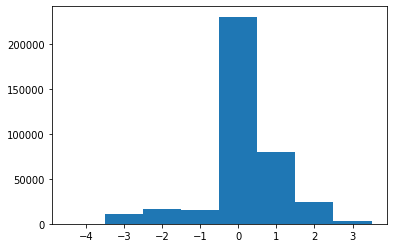

In [ ]:
# Verteilung der Sentiments

plt.hist(tweets['Sentiment'], bins=[-4, -3, -2, -1, 0, 1, 2, 3, 4], align='left', orientation='vertical')

In [ ]:
#Tweets mit Sentiment value von -4

tweets.loc[tweets['Sentiment'] == -4]['Text'].values

# Conversations

## Conversation-Finder

In [ ]:
# DataFrame enthält nur Kommentar-Tweets

comments = tweets[['ID', 'Original tweet ID (if comment)', 'Sentiment']].dropna()
len(comments)

9013

In [ ]:
# DataFrame enthält nur Reply-Tweets

reply = tweets[['ID', 'Original tweet ID (if reply)', 'Sentiment']].dropna()
len(reply)

159887

In [ ]:
# DataFrame enthält nur normale Tweets (Konversations-Starter)

endpoints = tweets[tweets['Original tweet ID (if comment)'].isna() & tweets['Original tweet ID (if reply)'].isna()][['ID', 'Sentiment']]
len(endpoints)

114436

In [ ]:
all = []
lst = []
counter = 0

# Anzahl der Tweets, die als potenzielle Konversations-Enden überprüft werden sollen
for y in range(len(reply)):

  conversation = []
  # Reply-Tweet und dessen Sentiment-Value in Konversations-Liste abspeichern
  conversation.append((reply.iat[y,0], reply.iat[y,2]))
  # Referenz-Tweet als Variable
  x = reply.iat[y,1]
  # Tweet an "Bereits verwendet"-Liste anhängen
  # lst.append(x) if (x not in lst) & (pd.isna(x) == False) else lst

  # Solang der Referenz-Tweet im Reply-Datensatz auftaucht, füge seine ID (und den Sentiment-Value) der Konversations-Liste hinzu
  # und speichere den neuen Referenz-Tweet als Variable
  # Füge jeden neuen Tweet der "Bereits verwendet"-Liste hinzu
  while len(reply.loc[reply['ID'] == x]) > 0:
    # counter += 1
    conversation.append((x, reply.loc[reply['ID'] == x].iat[0,2]))
    x = reply.loc[reply['ID'] == x].iat[0,1]
    # lst.append(x) if (x not in lst) & (pd.isna(x) == False) else lst

  # Das Selbe für den Kommentar-Datensatz ...
  while len(comments.loc[comments['ID'] == x]) > 0:
    # counter += 1
    conversation.append((x, comments.loc[comments['ID'] == x].iat[0,2]))
    x = comments.loc[comments['ID'] == x].iat[0,1]
    # lst.append(x) if (x not in lst) & (pd.isna(x) == False) else lst

  # Das Selbe wieder für den Reply-Datensatz ...
  while len(reply.loc[reply['ID'] == x]) > 0:
    # counter += 1
    conversation.append((x, reply.loc[reply['ID'] == x].iat[0,2]))
    x = reply.loc[reply['ID'] == x].iat[0,1]
    # lst.append(x) if (x not in lst) & (pd.isna(x) == False) else lst

  # Und ein letztes Mal der Kommentar-Datensatz ...
  while len(comments.loc[comments['ID'] == x]) > 0:
    # counter += 1
    conversation.append((x, comments.loc[comments['ID'] == x].iat[0,2]))
    x = comments.loc[comments['ID'] == x].iat[0,1]
    # lst.append(x) if (x not in lst) & (pd.isna(x) == False) else lst

  # Da keine weiteren Reply- oder Kommentar-Tweets gefunden wurden,
  # suche den letzten Referenz-Tweet bei den Konversations-Startern
  if len(endpoints.loc[endpoints['ID'] == x]) > 0:
    # counter += 1
    conversation.append((x, endpoints.loc[endpoints['ID'] == x].iat[0,1]))

  # Filtere für Konversationen, die länger als drei Tweets sind
  if len(conversation) > 2:
    all.append(conversation)
  # counter = 1

# Gesamtzahl der Konversationen
len(all)

94382

In [ ]:
# Gesamtlänge der Unique-Tweet-Liste

len(lst)

0

## Filtern und zwischenspeichern

In [ ]:
# Filtere nach negativen Konversationsstartern

starter = []
counter = 0

for i in range(len(all)):
  if all[i][-1][1] <= -3:
    starter.append((len(all[i]), all[i]))

len(starter)

2508

In [ ]:
matches = [x for x in starter if x[1][-1][1] == -3]
len(matches)

2421

In [ ]:
convo_list = []
id_list = []

for i in range(len(starter)):
  y = starter[i][1][-1][0]
  if y not in id_list:
    matches = [x for x in starter if x[1][-1][0] == y]
    convo_list.append(max(matches))
  id_list.append(y)

len(convo_list)

575

In [ ]:
final = []

for i in convo_list:
  final.append(i[1])

final

[[(1119266153199751169, 2),
  (1.1192656923967201e+18, 0),
  (1.1192071282989384e+18, 0),
  (1.1191964272410501e+18, -3)],
 [(1119514000667172865, 1),
  (1.1193419698582692e+18, 0),
  (1.1191566818526085e+18, 0),
  (1.1191505729830789e+18, -3)],
 [(1119562050404069376, 1),
  (1.1195584108973834e+18, -1),
  (1.1195257123089654e+18, 1),
  (1.1195134016324157e+18, -3)],
 [(1119570512110411776, 0),
  (1.1195695261636362e+18, 0),
  (1.1195661964316303e+18, 1),
  (1.1195658612100342e+18, 0),
  (1.11956189598652e+18, 0),
  (1.1195615596913623e+18, -3)],
 [(1120591133657182208, -1),
  (1.1205894185308406e+18, -1),
  (1.1205891199383429e+18, 0),
  (1.1205879860502118e+18, -3)],
 [(1120605730984345600, 0),
  (1.1205965126004613e+18, 0),
  (1.1205913908477747e+18, 0),
  (1.120587640485634e+18, -3)],
 [(1120695237574373379, -2),
  (1.1206922872379146e+18, -1),
  (1.1206911077535457e+18, 1),
  (1.1206884797410181e+18, 1),
  (1.1206882062556733e+18, -3)],
 [(1120746022832082944, 0),
  (1.12073812040

In [ ]:
for i in range(len(final)):
  for u in range(len(final[i])-1, -1, -1):
    print(tweets.loc[tweets['ID'] == final[i][u][0]][['Author screen name', 'Text']].values)
  print('\n\n')

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
[['bolleone' '@DB_Bahn Aber trotzdem vielen Dank für Eure Antwort!']]
[['DB_Bahn' '@bolleone Nichts zu danken. /aj']]



[['svoeth'
  'Hmm, @DB_Bahn macht meine "jeder 5. Zug ist (deutlich) zu spät" kaputt.  Leider nicht indem sie häufiger pünktlich kommt... #ice877 #GoingHome']]
[['svoeth'
  '@DB_Bahn Immer wieder toll mit der  @DB_Bahn : "Liebe Passagiere mit Reservierung für Wagen 6, bitte verteilen sie sich auf die Wagen 4 und 5" Zwei mal auf deutsch wiederholt - Keine weitere Begründung #zuspaetundkaputt #ice877 @BahnAnsagen']]
[['svoeth'
  '@DB_Bahn @BahnAnsagen oha, das Zugteam kämpft darum meine Statistik zu retten und hat auf halber Strecke schon fast die gesamte Verspätung eingeholt. #ice877']]
[['DB_Bahn'
  '@svoeth Wenn Sie bis Karlsruhe mitfahren, werden Sie voraussichtlich ganz leer ausgehen, denn bis dahin soll die Verspätung vollkommen aufgeholt sein. ? /da']]
[['svoeth'
  '@DB_Bahn So wie es aussieht so

In [ ]:
# df = pd.DataFrame(all)
# df.to_csv('/content/drive/MyDrive/21-09-03 DB NWOM/1008_Conversations.csv')
neu = pd.DataFrame(final)
neu.to_csv('/content/drive/MyDrive/21-09-03 DB NWOM/211104_Updated_Conversations.csv')
neu

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,"(1119266153199751169, 2)","(1.1192656923967201e+18, 0)","(1.1192071282989384e+18, 0)","(1.1191964272410501e+18, -3)",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,"(1119514000667172865, 1)","(1.1193419698582692e+18, 0)","(1.1191566818526085e+18, 0)","(1.1191505729830789e+18, -3)",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,"(1119562050404069376, 1)","(1.1195584108973834e+18, -1)","(1.1195257123089654e+18, 1)","(1.1195134016324157e+18, -3)",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,"(1119570512110411776, 0)","(1.1195695261636362e+18, 0)","(1.1195661964316303e+18, 1)","(1.1195658612100342e+18, 0)","(1.11956189598652e+18, 0)","(1.1195615596913623e+18, -3)",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,"(1120591133657182208, -1)","(1.1205894185308406e+18, -1)","(1.1205891199383429e+18, 0)","(1.1205879860502118e+18, -3)",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,"(1177702312938233862, 0)","(1.1776965233978614e+18, 0)","(1.1776958747486904e+18, -3)",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
571,"(1179140245780074496, 0)","(1.1791378319036498e+18, 0)","(1.1791351711252193e+18, -3)",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
572,"(1142431880463179776, 0)","(1.1424250193242767e+18, 0)","(1.1424139117333914e+18, -3)",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
573,"(1144579647168045057, 0)","(1.1445764031884001e+18, -1)","(1.1440975179839488e+18, 1)","(1.1439860437183816e+18, 1)","(1.14398552487458e+18, -3)","(1.1439282745334538e+18, -3)","(1.1439249941095752e+18, 1)","(1.1439244451213025e+18, 0)","(1.1439241028618609e+18, -3)",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


## Aktuellen Stand laden

In [ ]:
import ast 
from ast import literal_eval

In [ ]:
# Zwischenstand importieren 

aktuell = pd.read_csv('/content/drive/MyDrive/21-09-03 DB NWOM/211104_Updated_Conversations.csv')
aktuell.drop('Unnamed: 0', axis=1, inplace=True)
# converters={"0": ast.literal_eval, "1": ast.literal_eval, "2": ast.literal_eval, "3": ast.literal_eval, "4": ast.literal_eval, "5": ast.literal_eval, "6": ast.literal_eval, "7": ast.literal_eval, "8": ast.literal_eval, "9": ast.literal_eval, "10": ast.literal_eval, "11": ast.literal_eval, "12": ast.literal_eval, "13": ast.literal_eval, "14": ast.literal_eval, "15": ast.literal_eval, "16": ast.literal_eval, "17": ast.literal_eval, "18": ast.literal_eval, "19": ast.literal_eval, "20": ast.literal_eval, "21": ast.literal_eval, "22": ast.literal_eval, "23": ast.literal_eval, "24": ast.literal_eval, "25": ast.literal_eval, "26": ast.literal_eval, "27": ast.literal_eval}

In [ ]:
# ???
aktuell = aktuell.values.tolist()

In [ ]:
cleanedList = [[literal_eval(str(i)) for i in x if str(i) != 'nan'] for x in aktuell ]

In [ ]:
all = cleanedList

## Filtern

In [ ]:
# Füge Sentiments hinzu

starter = []
counter = 0

for i in range(len(all)):
  if all[i][-1][1] <= -3:
    starter.append((len(all[i]), all[i]))

len(starter)

575

In [ ]:
# Filtere nach Sentiments

convo_list = []
id_list = []

for i in range(len(starter)):
  y = starter[i][1][-1][0]
  if y not in id_list:
    matches = [x for x in starter if x[1][-1][0] == y]
    convo_list.append(max(matches))
  id_list.append(y)

len(convo_list)

575

In [ ]:
# Entferne Sentiments

final = []

for i in convo_list:
  final.append(i[1])

len(final)

575

In [ ]:
# Finde die IDs der Bahn-Accounts und speichere sie in einer Liste

db =['DB_Bahn', 'streckenagent_M', 'Regio_NRW', 'DBRegio_SH', 'DB_Presse', 'DB_Info', 'DBRegio_NDS', 'streckenagentNB', 'streckenagentFR', 'streckenagent_N', 'streckenagentAS']

db_IDs = []

for i in db:
  # print(tweets.loc[tweets['Author screen name'] == i]['Author ID'])
  db_IDs.append(tweets.loc[tweets['Author screen name'] == i]['Author ID'].iloc[0])

db_IDs

[39999078,
 1341592290,
 163576129,
 1075034762098737153,
 18565652,
 14330924,
 814393643125604352,
 1341657584,
 1341620324,
 1339190454,
 1341612912]

In [ ]:
# Filtere Konversationen, in denen DB-Accounts involviert sind

relevant = []

for i in final:
  # print(i)
  for u in i:
    if tweets.loc[tweets['ID'] == u[0]]['Author ID'].values[0] in db_IDs:
      relevant.append(i)
      break
      # print('!')
len(relevant)

424

In [ ]:
# Zeige relevante Konversationen
author = []
tweet = []
sentiment = []

for i in range(len(relevant)):
  # print(final[i])
  for u in range(len(relevant[i])-1, -1, -1):
    print(relevant[i][u][1])
    sentiment.append(relevant[i][u][1])
    print(tweets.loc[tweets['ID'] == relevant[i][u][0]][['Author screen name', 'Text']].values)
    author.append(tweets.loc[tweets['ID'] == relevant[i][u][0]]['Author screen name'].values)
    tweet.append(tweets.loc[tweets['ID'] == relevant[i][u][0]]['Text'].values)
  author.append('')
  tweet.append('')
  sentiment.append('')
  print('\n\n')

df = pd.DataFrame()
df['Author screen name'] = author
df['Tweet'] = tweet
df['Sentiment'] = sentiment

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.


-3
[['EinAugenschmaus'
  'Wieder mal ist die Schwerbehindertentoilette im Wagen 9 des ICE 77 (da, wo in den meisten meisten ICES die Schwerbehindertenplätze sind) defekt und nicht zugänglich. Doppelt ärgerlich, weil da eben auch der Wickeltisch ist. :-( @DB_Bahn']]
-2
[['DB_Bahn'
  '@EinAugenschmaus Das ist natürlich großer Mist. ? Sorry für die jetzt entstehenden Umstände. /mi']]
0
[['EinAugenschmaus'
  '@DB_Bahn Das ist die dritte Zugfahrt im Abstand von wenigen Tagen mit dem Umstand einer defekten Schwerbehindertentoilette. Wird sowas nicht umgehend repariert?']]
1
[['DB_Bahn'
  '@EinAugenschmaus Das wird im Werk repariert. Je nachdem, was es für ein Defekt ist, geht das mal schneller und mal müssen Ersatzteile bestellt werden. In den vielen Fällen sind es Verstopfungen, weil die Papierhandtücher im WC entsorgt werden oder 2 Meter Toilettenpapier benutzt wird. ? /mi']]
0
[['EinAugenschmaus'
  '@DB_Bahn Kann man die

In [ ]:
df.to_csv('/content/drive/MyDrive/21-09-03 DB NWOM/Final Conversations/21_11_04 Conversations.csv')